# Bartosz Bogucki 82801

**Wczytanie bibliotek**

In [1]:
#Keras:
import keras
from keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, Flatten, Reshape
from keras import Input, Model, callbacks
from keras.models import Sequential, load_model
from keras.utils import plot_model, to_categorical
from keras.datasets import fashion_mnist
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks
from keras import backend as K

#inne:
from matplotlib import pyplot as plt
import numpy as np
from numpy import dstack
from scipy import stats
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
import json
import bson
from bson.objectid import ObjectId

**Ładowanie danych i pre-processing**

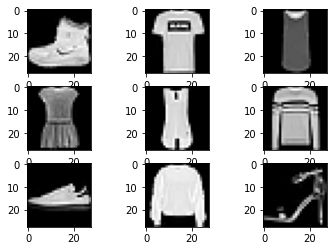

In [147]:
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()

for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
plt.show()

In [148]:
#Pre-processing
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

X_train = X_train/255.
X_test = X_test/255.

Y_train = to_categorical(Y_train,10)
Y_test = to_categorical(Y_test,10)

**Definiujemy dwie architektury modeli sztucznych sieci neuronowych.** W czasie wstępnych badań nad klasyfikacją danych Fashion MNIST udało się uzyskać dwie poniższe architektury, które osiągają relatywnie dobre wyniki. Używamy dwóch architektur, ponieważ chcemy porównać, która okaże się lepsza, a także w finalnym kroku chcemy stosować metody zespołowe (ang. ensemble methods), dlatego wiedza z obu zdefiniowanych modeli może okazać się przydatna. Oba modele są dość złożone i mają ponad milion parametrów, jednak są na tyle proste żeby trening modelu nie trwał zbyt długo (relatywnie proste w porównaniu np. do modelu VGG16, który ma łącznie 138 milionów parametrów).

In [5]:
cnn1 = Sequential([
    Conv2D(32, kernel_size=3, activation='relu', padding='same', input_shape=(28,28,1)),
    BatchNormalization(),
    Conv2D(32, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(32, kernel_size=5, strides=2, padding='same', activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Conv2D(64, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, kernel_size=5, strides=2, padding='same', activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Conv2D(128, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, kernel_size=5, strides=2, padding='same', activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(10, activation='softmax')
    ])

cnn2 = Sequential([
    Conv2D(32, kernel_size=3, activation='relu', input_shape=(28, 28, 1), name='Conv2D_1'),
    BatchNormalization(name='BatchNormalization_1'),
    Conv2D(32, kernel_size=3, activation='relu', name='Conv2D_2'),
    BatchNormalization(name='BatchNormalization_2'),
    MaxPooling2D(pool_size=2, name='MaxPool_1'),
    Dropout(0.25, name='Dropout_1'),
    Conv2D(64, kernel_size=3, activation='relu', name='Conv2D_3'),
    BatchNormalization(name='BatchNormalization_3'),
    Dropout(0.25, name='Dropout_2'),
    Conv2D(128, kernel_size=3, activation='relu', name='Conv2D_4'),
    BatchNormalization(name='BatchNormalization_4'),
    MaxPooling2D(pool_size=2, name='MaxPool_2'),
    Dropout(0.25, name='Dropout_3'),
    Flatten(name='Flatten'),
    Dense(512, activation='relu', name='Dense_1'),
    BatchNormalization(name='BatchNormalization_5'),
    Dropout(0.5, name='Dropout_4'),
    Dense(128, activation='relu', name='Dense_2'),
    BatchNormalization(name='BatchNormalization_6'),
    Dropout(0.5, name='Dropout_5'),
    Dense(10, activation='softmax', name='Output')
    ])

cnn1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])
cnn2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])

2023-03-19 00:39:31.039847: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-19 00:39:48.078641: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7422 MB memory:  -> device: 0, name: Tesla M60, pci bus id: 0001:00:00.0, compute capability: 5.2


In [6]:
cnn1.summary()
cnn2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 32)        25632     
                                                                 
 batch_normalization_2 (Batc  (None, 14, 14, 32)       1

**Trening modelu**

**Krok 1:** Po pierwsze, trenujemy dany model na danych treningowych bez modyfikacji z redukcją parametru uczenia (ang. learing rate) mnożąc go razy 0.5, jeśli w ciągu ostatnich 10 epok (ang. epoch) nie było poprawy wartości miary dokładności (ang. accuracy) na zbiorze testowym. Dodaktkowo, jeśli w ciągu ostatnich 20 epok nie było poprawy wartości miary dokładności na zbiorze treningowym algorytm zostanie przerwany. Zapisujemy model o największej miarze dokładności na zbiorze testowym.
W wyniku tego treningu dostajemy przetrenowany (ang. overfitted) model - sieć jest bardzo dobrze dopasowana do danych treningowych i relatywnie gorzej wypada na danych testowych. Jest to jednak pierwszy krok i model uzykany w tym etapie stosujemy jako inicjalny, a w drugim kroku zastosujemy technikę augmentacji danych (ang. data augmentation) na zbiorze treningowych tzn. sztucznie stworzymy zmodyfikowane kopie zbioru treningowego przy użyciu istniejących danych.

In [7]:
#callbacks
es = callbacks.EarlyStopping(monitor='val_accuracy', mode='max', verbose=0, patience=20, restore_best_weights=True)
rlr = callbacks.ReduceLROnPlateau(monitor = 'val_accuracy', mode='max', factor = 0.5, patience =10)
mc = callbacks.ModelCheckpoint('best_initial_cnn1.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)

#fit
init_history = cnn1.fit(X_train,Y_train,
                       batch_size=32,
                       epochs=100,
                       verbose=1,
                       validation_data=(X_test, Y_test),
                       callbacks=[es,rlr,mc])
#fit
mc = callbacks.ModelCheckpoint('best_initial_cnn2.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)
init_history2 = cnn2.fit(X_train,Y_train,
                       batch_size=32,
                       epochs=100,
                       verbose=1,
                       validation_data=(X_test, Y_test),
                       callbacks=[es,rlr,mc])

Epoch 1/100


2023-03-19 00:41:30.377265: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-03-19 00:41:49.998040: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2023-03-19 00:42:12.954480: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-19 00:42:34.793500: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7faf896847f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-19 00:42:34.793539: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla M60, Compute Capability 5.2
2023-03-19 00:42:35.515933: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `

1875/1875 [==============================] - 108s 14ms/step - loss: 0.5460 - accuracy: 0.8062 - val_loss: 0.3743 - val_accuracy: 0.8679 - lr: 0.0010
Epoch 2/100
1875/1875 [==============================] - 26s 14ms/step - loss: 0.3453 - accuracy: 0.8741 - val_loss: 0.3711 - val_accuracy: 0.8697 - lr: 0.0010
Epoch 3/100
1875/1875 [==============================] - 26s 14ms/step - loss: 0.3025 - accuracy: 0.8893 - val_loss: 0.2628 - val_accuracy: 0.9041 - lr: 0.0010
Epoch 4/100
1875/1875 [==============================] - 26s 14ms/step - loss: 0.2728 - accuracy: 0.9017 - val_loss: 0.2419 - val_accuracy: 0.9103 - lr: 0.0010
Epoch 5/100
1875/1875 [==============================] - 26s 14ms/step - loss: 0.2498 - accuracy: 0.9101 - val_loss: 0.2490 - val_accuracy: 0.9110 - lr: 0.0010
Epoch 6/100
1875/1875 [==============================] - 26s 14ms/step - loss: 0.2306 - accuracy: 0.9166 - val_loss: 0.2447 - val_accuracy: 0.9145 - lr: 0.0010
Epoch 7/100
1875/1875 [============================

2023-03-19 01:21:52.646607: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/Dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1875/1875 [==============================] - 19s 8ms/step - loss: 0.6060 - accuracy: 0.7869 - val_loss: 0.3693 - val_accuracy: 0.8641 - lr: 0.0010
Epoch 2/100
1875/1875 [==============================] - 14s 7ms/step - loss: 0.3927 - accuracy: 0.8629 - val_loss: 0.3081 - val_accuracy: 0.8906 - lr: 0.0010
Epoch 3/100
1875/1875 [==============================] - 14s 7ms/step - loss: 0.3460 - accuracy: 0.8775 - val_loss: 0.2835 - val_accuracy: 0.8951 - lr: 0.0010
Epoch 4/100
1875/1875 [==============================] - 14s 7ms/step - loss: 0.3201 - accuracy: 0.8856 - val_loss: 0.2513 - val_accuracy: 0.9099 - lr: 0.0010
Epoch 5/100
1875/1875 [==============================] - 14s 7ms/step - loss: 0.2949 - accuracy: 0.8951 - val_loss: 0.3007 - val_accuracy: 0.8867 - lr: 0.0010
Epoch 6/100
1875/1875 [==============================] - 14s 7ms/step - loss: 0.2773 - accuracy: 0.9021 - val_loss: 0.2643 - val_accuracy: 0.9020 - lr: 0.0010
Epoch 7/100
1875/1875 [==============================] - 1

**Krok 2**: Jak wspomniałem wyżej, w drugim kroku stostujemy augmentacje danych treningowych i trenujemy na sztucznie wygenerowanym zbiorze najlepsze inicjalny modele otrzymany w kroku 1 (najlepiej dopasowane do danych testowych). Zmieniamy jednak jego początkowy parametr uczenia ponownie na 0.001. Trenujemy pojedynczy model niezależnie 5 razy, uzyskując 5 różnych modeli sieci neuronowych danej architektury - w kolejnym 3 kroku wykorzystujemy następnie wiedze z wszystkich modeli stosując metody zespołowe. Trenujemy modele na danych treningowych po augmentacji z redukcją parametru uczenia mnożąc go razy 0.5, jeśli w ciągu ostatnich 20 epok nie było poprawy wartości miary dokładności na zbiorze testowym. Dodatkowo, jeśli w ciągu ostatnich 50 epok nie było poprawy wartości miary dokładności na zbiorze treningowym algorytm zostanie przerwany. Zapisujemy modele o największej miarze dokładności na zbiorze testowym.

In [8]:
#5 modeli
n=5
history=[0]*n

#data augmentation
data_gen = ImageDataGenerator(rotation_range=9,
                              zoom_range=0.09,
                              width_shift_range=0.09,
                              height_shift_range=0.09,
                              horizontal_flip=True
                             )

#callbacks
es = callbacks.EarlyStopping(monitor='val_accuracy', mode='max', verbose=0, patience=50, restore_best_weights=True)
rlr = callbacks.ReduceLROnPlateau(monitor = 'val_accuracy', mode='max', factor=0.5, patience=20)

for i in range(n):
    #wczytanie inicjalnego modelu
    model = load_model("best_initial_cnn1.h5")
    K.set_value(model.optimizer.lr, 0.001)
    #zapisywanie najlepszego wyćwiczonego modelu na danych treningowych po modyfikacjach
    mc = callbacks.ModelCheckpoint(f'best_cnn1_{i}.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)
    #fit
    history[i] = model.fit(data_gen.flow(X_train,Y_train, batch_size=32),
                           steps_per_epoch=len(X_train)/32,
                           epochs=300,
                           verbose=1,
                           validation_data=(X_test, Y_test),
                           callbacks=[es,rlr,mc])

Epoch 1/300


2023-03-19 01:44:39.212338: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1875/1875 [==============================] - 34s 15ms/step - loss: 0.4330 - accuracy: 0.8568 - val_loss: 0.2001 - val_accuracy: 0.9304 - lr: 0.0010
Epoch 2/300
1875/1875 [==============================] - 27s 15ms/step - loss: 0.3233 - accuracy: 0.8856 - val_loss: 0.1953 - val_accuracy: 0.9332 - lr: 0.0010
Epoch 3/300
1875/1875 [==============================] - 27s 14ms/step - loss: 0.2998 - accuracy: 0.8918 - val_loss: 0.2025 - val_accuracy: 0.9285 - lr: 0.0010
Epoch 4/300
1875/1875 [==============================] - 27s 14ms/step - loss: 0.2860 - accuracy: 0.8978 - val_loss: 0.1999 - val_accuracy: 0.9279 - lr: 0.0010
Epoch 5/300
1875/1875 [==============================] - 27s 14ms/step - loss: 0.2781 - accuracy: 0.9003 - val_loss: 0.2118 - val_accuracy: 0.9235 - lr: 0.0010
Epoch 6/300
1875/1875 [==============================] - 27s 14ms/step - loss: 0.2709 - accuracy: 0.9025 - val_loss: 0.1938 - val_accuracy: 0.9275 - lr: 0.0010
Epoch 7/300
1875/1875 [=============================

2023-03-19 03:03:18.120298: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1875/1875 [==============================] - 34s 15ms/step - loss: 0.4357 - accuracy: 0.8549 - val_loss: 0.2127 - val_accuracy: 0.9247 - lr: 0.0010
Epoch 2/300
1875/1875 [==============================] - 27s 15ms/step - loss: 0.3221 - accuracy: 0.8845 - val_loss: 0.1978 - val_accuracy: 0.9297 - lr: 0.0010
Epoch 3/300
1875/1875 [==============================] - 27s 14ms/step - loss: 0.2986 - accuracy: 0.8928 - val_loss: 0.2006 - val_accuracy: 0.9279 - lr: 0.0010
Epoch 4/300
1875/1875 [==============================] - 27s 14ms/step - loss: 0.2873 - accuracy: 0.8970 - val_loss: 0.2205 - val_accuracy: 0.9185 - lr: 0.0010
Epoch 5/300
1875/1875 [==============================] - 27s 14ms/step - loss: 0.2783 - accuracy: 0.9006 - val_loss: 0.2114 - val_accuracy: 0.9245 - lr: 0.0010
Epoch 6/300
1875/1875 [==============================] - 27s 14ms/step - loss: 0.2641 - accuracy: 0.9057 - val_loss: 0.1972 - val_accuracy: 0.9286 - lr: 0.0010
Epoch 7/300
1875/1875 [=============================

2023-03-19 04:55:13.597141: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1875/1875 [==============================] - 34s 15ms/step - loss: 0.4359 - accuracy: 0.8553 - val_loss: 0.1991 - val_accuracy: 0.9334 - lr: 0.0010
Epoch 2/300
1875/1875 [==============================] - 27s 14ms/step - loss: 0.3243 - accuracy: 0.8852 - val_loss: 0.1966 - val_accuracy: 0.9314 - lr: 0.0010
Epoch 3/300
1875/1875 [==============================] - 27s 14ms/step - loss: 0.3028 - accuracy: 0.8911 - val_loss: 0.2063 - val_accuracy: 0.9262 - lr: 0.0010
Epoch 4/300
1875/1875 [==============================] - 27s 14ms/step - loss: 0.2860 - accuracy: 0.8987 - val_loss: 0.2116 - val_accuracy: 0.9241 - lr: 0.0010
Epoch 5/300
1875/1875 [==============================] - 27s 14ms/step - loss: 0.2790 - accuracy: 0.8999 - val_loss: 0.1941 - val_accuracy: 0.9312 - lr: 0.0010
Epoch 6/300
1875/1875 [==============================] - 27s 14ms/step - loss: 0.2682 - accuracy: 0.9041 - val_loss: 0.2016 - val_accuracy: 0.9268 - lr: 0.0010
Epoch 7/300
1875/1875 [=============================

2023-03-19 06:14:42.397460: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1875/1875 [==============================] - 34s 15ms/step - loss: 0.4337 - accuracy: 0.8567 - val_loss: 0.2196 - val_accuracy: 0.9275 - lr: 0.0010
Epoch 2/300
1875/1875 [==============================] - 27s 14ms/step - loss: 0.3213 - accuracy: 0.8857 - val_loss: 0.1972 - val_accuracy: 0.9306 - lr: 0.0010
Epoch 3/300
1875/1875 [==============================] - 27s 14ms/step - loss: 0.2995 - accuracy: 0.8920 - val_loss: 0.2000 - val_accuracy: 0.9283 - lr: 0.0010
Epoch 4/300
1875/1875 [==============================] - 27s 14ms/step - loss: 0.2833 - accuracy: 0.8976 - val_loss: 0.2179 - val_accuracy: 0.9209 - lr: 0.0010
Epoch 5/300
1875/1875 [==============================] - 27s 14ms/step - loss: 0.2751 - accuracy: 0.9020 - val_loss: 0.2009 - val_accuracy: 0.9285 - lr: 0.0010
Epoch 6/300
1875/1875 [==============================] - 27s 14ms/step - loss: 0.2660 - accuracy: 0.9048 - val_loss: 0.1929 - val_accuracy: 0.9329 - lr: 0.0010
Epoch 7/300
1875/1875 [=============================

2023-03-19 07:57:37.864931: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1875/1875 [==============================] - 34s 15ms/step - loss: 0.4377 - accuracy: 0.8543 - val_loss: 0.2159 - val_accuracy: 0.9279 - lr: 0.0010
Epoch 2/300
1875/1875 [==============================] - 27s 14ms/step - loss: 0.3208 - accuracy: 0.8854 - val_loss: 0.2035 - val_accuracy: 0.9298 - lr: 0.0010
Epoch 3/300
1875/1875 [==============================] - 27s 14ms/step - loss: 0.2986 - accuracy: 0.8947 - val_loss: 0.1981 - val_accuracy: 0.9294 - lr: 0.0010
Epoch 4/300
1875/1875 [==============================] - 27s 14ms/step - loss: 0.2822 - accuracy: 0.8984 - val_loss: 0.1983 - val_accuracy: 0.9296 - lr: 0.0010
Epoch 5/300
1875/1875 [==============================] - 27s 14ms/step - loss: 0.2781 - accuracy: 0.9004 - val_loss: 0.2127 - val_accuracy: 0.9249 - lr: 0.0010
Epoch 6/300
1875/1875 [==============================] - 27s 15ms/step - loss: 0.2702 - accuracy: 0.9037 - val_loss: 0.1986 - val_accuracy: 0.9311 - lr: 0.0010
Epoch 7/300
1875/1875 [=============================

In [10]:
#5 modeli
history2=[0]*n

for i in range(n):
    #wczytanie inicjalnego modelu
    model = load_model("best_initial_cnn2.h5")
    K.set_value(model.optimizer.lr, 0.001)
    #zapisywanie najlepszego wyćwiczonego modelu na danych treningowych po modyfikacjach
    mc = callbacks.ModelCheckpoint(f'best_cnn2_{i}.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)
    #fit
    history2[i] = model.fit(data_gen.flow(X_train,Y_train, batch_size=32),
                           steps_per_epoch=len(X_train)/32,
                           epochs=300,
                           verbose=1,
                           validation_data=(X_test, Y_test),
                           callbacks=[es,rlr,mc])

Epoch 1/300


2023-03-19 11:07:14.825188: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/Dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1875/1875 [==============================] - 27s 12ms/step - loss: 0.5038 - accuracy: 0.8313 - val_loss: 0.2131 - val_accuracy: 0.9276 - lr: 0.0010
Epoch 2/300
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3853 - accuracy: 0.8676 - val_loss: 0.2103 - val_accuracy: 0.9270 - lr: 0.0010
Epoch 3/300
1875/1875 [==============================] - 22s 11ms/step - loss: 0.3631 - accuracy: 0.8718 - val_loss: 0.2189 - val_accuracy: 0.9210 - lr: 0.0010
Epoch 4/300
1875/1875 [==============================] - 22s 11ms/step - loss: 0.3490 - accuracy: 0.8762 - val_loss: 0.2093 - val_accuracy: 0.9235 - lr: 0.0010
Epoch 5/300
1875/1875 [==============================] - 22s 12ms/step - loss: 0.3341 - accuracy: 0.8812 - val_loss: 0.2102 - val_accuracy: 0.9231 - lr: 0.0010
Epoch 6/300
1875/1875 [==============================] - 22s 12ms/step - loss: 0.3280 - accuracy: 0.8845 - val_loss: 0.1998 - val_accuracy: 0.9279 - lr: 0.0010
Epoch 7/300
1875/1875 [=============================

2023-03-19 12:28:17.087806: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/Dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1875/1875 [==============================] - 26s 12ms/step - loss: 0.4928 - accuracy: 0.8372 - val_loss: 0.2330 - val_accuracy: 0.9191 - lr: 0.0010
Epoch 2/300
1875/1875 [==============================] - 22s 12ms/step - loss: 0.3867 - accuracy: 0.8647 - val_loss: 0.2022 - val_accuracy: 0.9282 - lr: 0.0010
Epoch 3/300
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3602 - accuracy: 0.8719 - val_loss: 0.2125 - val_accuracy: 0.9225 - lr: 0.0010
Epoch 4/300
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3490 - accuracy: 0.8782 - val_loss: 0.2226 - val_accuracy: 0.9201 - lr: 0.0010
Epoch 5/300
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3350 - accuracy: 0.8818 - val_loss: 0.2052 - val_accuracy: 0.9242 - lr: 0.0010
Epoch 6/300
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3234 - accuracy: 0.8853 - val_loss: 0.2059 - val_accuracy: 0.9260 - lr: 0.0010
Epoch 7/300
1875/1875 [=============================

2023-03-19 14:15:13.386886: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/Dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1875/1875 [==============================] - 26s 12ms/step - loss: 0.4854 - accuracy: 0.8399 - val_loss: 0.2139 - val_accuracy: 0.9276 - lr: 0.0010
Epoch 2/300
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3867 - accuracy: 0.8651 - val_loss: 0.2131 - val_accuracy: 0.9261 - lr: 0.0010
Epoch 3/300
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3616 - accuracy: 0.8731 - val_loss: 0.2207 - val_accuracy: 0.9228 - lr: 0.0010
Epoch 4/300
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3442 - accuracy: 0.8774 - val_loss: 0.2218 - val_accuracy: 0.9184 - lr: 0.0010
Epoch 5/300
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3351 - accuracy: 0.8809 - val_loss: 0.2063 - val_accuracy: 0.9258 - lr: 0.0010
Epoch 6/300
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3268 - accuracy: 0.8842 - val_loss: 0.2058 - val_accuracy: 0.9247 - lr: 0.0010
Epoch 7/300
1875/1875 [=============================

2023-03-19 15:05:47.207639: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/Dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1875/1875 [==============================] - 26s 12ms/step - loss: 0.4885 - accuracy: 0.8374 - val_loss: 0.2023 - val_accuracy: 0.9308 - lr: 0.0010
Epoch 2/300
1875/1875 [==============================] - 22s 11ms/step - loss: 0.3843 - accuracy: 0.8658 - val_loss: 0.2158 - val_accuracy: 0.9227 - lr: 0.0010
Epoch 3/300
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3582 - accuracy: 0.8736 - val_loss: 0.2095 - val_accuracy: 0.9243 - lr: 0.0010
Epoch 4/300
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3461 - accuracy: 0.8779 - val_loss: 0.2148 - val_accuracy: 0.9224 - lr: 0.0010
Epoch 5/300
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3327 - accuracy: 0.8830 - val_loss: 0.2074 - val_accuracy: 0.9249 - lr: 0.0010
Epoch 6/300
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3207 - accuracy: 0.8865 - val_loss: 0.1944 - val_accuracy: 0.9291 - lr: 0.0010
Epoch 7/300
1875/1875 [=============================

Bad pipe message: %s [b'`\xf6[63\xc8\x00']
Bad pipe message: %s [b"\xc1\xa84\xe2\x1c\x14\xf8m\xf1 u0Ov\xcf4\xd2\xca<R\x8dboT\xad'\x0b/\xb7\xfcOy0\xc1\xd0\xe2\xfa\xf7\xd1\xf65\xf5\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05\x03\x06\x03\x08\x07\x08\x08\x08\t\x08\n\x08\x0b\x08\x04\x08\x05\x08\x06\x04\x01\x05\x01\x06\x01\x00+\x00\x03\x02\x03\x04\x00-\x00\x02\x01\x01\x003\x00&\x00$\x00\x1d\x00 ^\x13\xd8\xe3 j\xeb\xc3<\xf0-\x18\xbe\x0f\xf5r\xd4fM\xfb\xb3c\x16\xa7\xa4\x1d\x12"]
Bad pipe message: %s [b"a!@Y\x8c@\x9a\xe1\x10\xa3s]\xc0=w\x0f\xdf\xb3\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0#\xc0'\x00g\x00

1875/1875 [==============================] - 22s 11ms/step - loss: 0.1970 - accuracy: 0.9301 - val_loss: 0.1694 - val_accuracy: 0.9402 - lr: 2.5000e-04
Epoch 209/300
1875/1875 [==============================] - 21s 11ms/step - loss: 0.1994 - accuracy: 0.9303 - val_loss: 0.1744 - val_accuracy: 0.9376 - lr: 2.5000e-04
Epoch 210/300
1875/1875 [==============================] - 21s 11ms/step - loss: 0.1959 - accuracy: 0.9303 - val_loss: 0.1707 - val_accuracy: 0.9397 - lr: 2.5000e-04
Epoch 211/300
1875/1875 [==============================] - 21s 11ms/step - loss: 0.1969 - accuracy: 0.9297 - val_loss: 0.1726 - val_accuracy: 0.9390 - lr: 2.5000e-04
Epoch 212/300
1875/1875 [==============================] - 22s 11ms/step - loss: 0.1958 - accuracy: 0.9309 - val_loss: 0.1734 - val_accuracy: 0.9382 - lr: 1.2500e-04
Epoch 213/300
1875/1875 [==============================] - 21s 11ms/step - loss: 0.1922 - accuracy: 0.9307 - val_loss: 0.1736 - val_accuracy: 0.9380 - lr: 1.2500e-04
Epoch 214/300
1875

2023-03-19 16:35:45.699205: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/Dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1875/1875 [==============================] - 26s 12ms/step - loss: 0.4924 - accuracy: 0.8352 - val_loss: 0.2036 - val_accuracy: 0.9303 - lr: 0.0010
Epoch 2/300
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3833 - accuracy: 0.8645 - val_loss: 0.2334 - val_accuracy: 0.9155 - lr: 0.0010
Epoch 3/300
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3632 - accuracy: 0.8716 - val_loss: 0.2070 - val_accuracy: 0.9250 - lr: 0.0010
Epoch 4/300
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3437 - accuracy: 0.8798 - val_loss: 0.2096 - val_accuracy: 0.9239 - lr: 0.0010
Epoch 5/300
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3323 - accuracy: 0.8834 - val_loss: 0.2066 - val_accuracy: 0.9264 - lr: 0.0010
Epoch 6/300
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3287 - accuracy: 0.8847 - val_loss: 0.2135 - val_accuracy: 0.9220 - lr: 0.0010
Epoch 7/300
1875/1875 [=============================

In [87]:
#załadaowanie modeli
models=[0]*2*n

for i in range(n):
    models[i]=load_model(f'best_cnn1_{i}.h5')
    models[i+5]=load_model(f'best_cnn2_{i}.h5')

#ewaluacja wyników
for i in range(2*n):
    _, acc = models[i].evaluate(X_test, Y_test, verbose=0)
    if i<=4:
        print(f'Model cnn1_{i} test accuracy: %.4f' % acc)
    if i>4:
        print(f'Model cnn2_{i-5} test accuracy: %.4f' % acc)

Model cnn1_0 test accuracy: 0.9491
Model cnn1_1 test accuracy: 0.9496
Model cnn1_2 test accuracy: 0.9485
Model cnn1_3 test accuracy: 0.9503
Model cnn1_4 test accuracy: 0.9484
Model cnn2_0 test accuracy: 0.9405
Model cnn2_1 test accuracy: 0.9422
Model cnn2_2 test accuracy: 0.9406
Model cnn2_3 test accuracy: 0.9417
Model cnn2_4 test accuracy: 0.9415


W wyniku treningu udało się już uzyskać model: cnn1_3, którego miara dokładności na zbiorze testowym wynosi powyżej 95% - dokładnie **95.03%**. Chcemy jednak sprawdzić, czy metody zespołowe poprawią jeszcze nasze wyniki.

**3 krok**: Finalny krok polega zatem na połączeniu przewidywań wytrenowanych w poprzednim kroku 10 modeli - po 5 modeli sieci neuronowych każdej architektury. Łączymy przewidywania za pomocą algorytmu głosowania (ensemble voting) i algorytmu stosowego (ensemble stacking) w celu sprawdzenia możliwości poprawy wyników miary dokładności na zbiorze testowym. Algorytm głosowania będzie polegał na wyborze najczęstszej klasyfikacji wśród modeli jako finalnej. Algorytm stosowy wykorzystywać będzie sieci neuronowe jako podmodele i klasyfikator regresji logistycznej jako meta-uczeń (ang. meta-learner).

*ensemble voting*

In [88]:
output = []
for m in models:
    predicts = np.argmax(m.predict(X_test, verbose=0), axis=1)
    output.append(predicts)
output = np.array(output)
output = np.transpose(output, (1, 0))
output = scipy.stats.mode(output, axis=-1)[0]
output = np.squeeze(output)

Y_test = np.argmax(Y_test,axis=1)
test_acc = sum(output==Y_test)/output.size
print('Test accuracy of voting ensemble: %.4f' % (test_acc))

Test accuracy of voting ensemble: 0.9501


In [89]:
#ensemble voting wykorzystując tylko cnn1
output = []
for m in models[0:5]:
    predicts = np.argmax(m.predict(X_test, verbose=0), axis=1)
    output.append(predicts)
output = np.array(output)
output = np.transpose(output, (1, 0))
output = scipy.stats.mode(output, axis=-1)[0]
output = np.squeeze(output)

test_acc = sum(output==Y_test)/output.size
print('Test accuracy of voting ensemble using only cnn1: %.4f' % (test_acc))

Test accuracy of voting ensemble using only cnn1: 0.9518


W wyniku użycia algorytmu głosowania nie udało się poprawić wyników korzystając z wszystkich uzyskanych modeli - uzyskany wynik miary dokładności na zbiorze testowym 95.01% jest mniejszy niż w najlepszym pojedynczym modelu. Jednak korzystając ze wszystkich 5 modeli uzyskane wyłącznie z architektury cnn1 i wykluczając modele cnn2 udało uzyskać się lepszy wynik niż rezultat najlepszej predykcji pojedynczego modelu uzyskując **95.18%** miary dokładności na zbiorze testowym. 

*ensemble stacking*

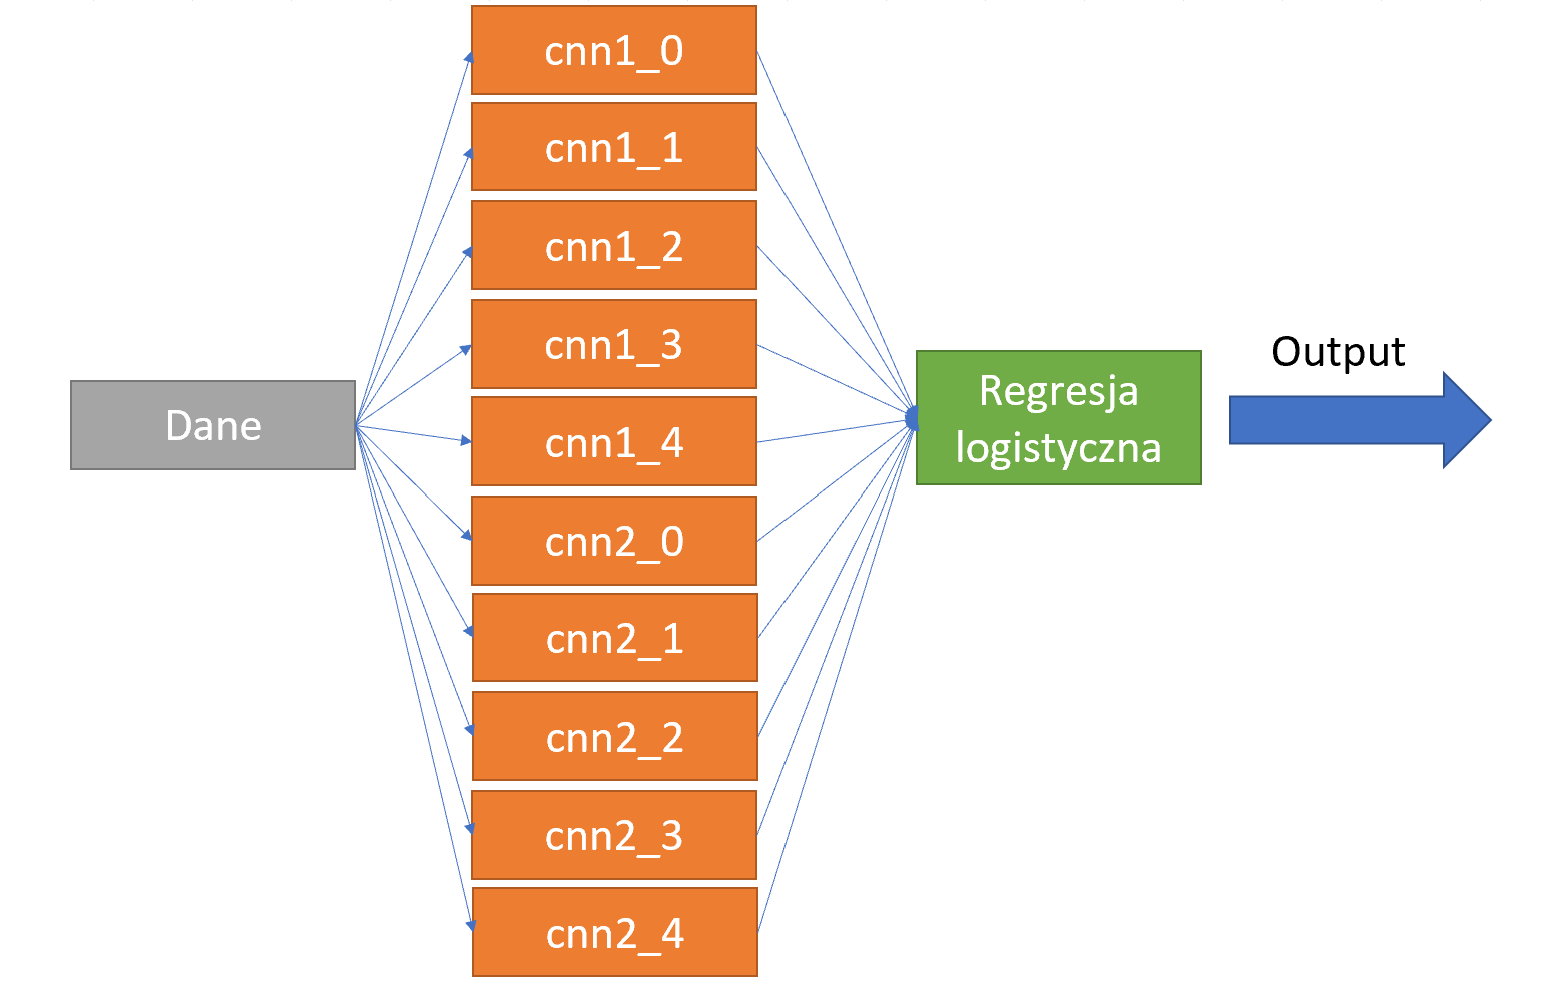

In [66]:
def stacked_dataset(members, inputX):
    stackX = None
    for model in members:
        yhat = model.predict(inputX, verbose=0)
        if stackX is None:
            stackX = yhat
        else:
            stackX = dstack((stackX, yhat))
    stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
    return stackX

def fit_stacked_model(members, inputX, inputy):
    stackedX = stacked_dataset(members, inputX)
    model = LogisticRegression()
    model.fit(stackedX, inputy)
    return model

def stacked_prediction(members, model, inputX):
    stackedX = stacked_dataset(members, inputX)
    yhat = model.predict(stackedX)
    return yhat

In [141]:
model = fit_stacked_model(models, X_test, Y_test)
yhat = stacked_prediction(models, model, X_test)
acc = accuracy_score(Y_test, yhat)
print('Stacked Test Accuracy: %.4f' % acc)

C:\Users\barte\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Stacked Test Accuracy: 0.9536


Finalnie, dzięki zasotosowaniu algorytmu stosowego wykorzystującego uzykane sieci neuronowe jako podmodele i klasyfikator regresji logistycznej jako meta-uczeń udaje się uzyskać wartość **95.36%** miary dokładności na zbiorze testowym. To najlepszy uzyskany wynik podczas tego badania - można zauwać, że zastosowanie technik zespołowych polepszyło wyniki predykcji. W dalszych badaniach nad zagnienieniem można wprowadzać dalsze alternatywne modeli sieci neuronowe z danymi architekturami do ewaluacji i użycia w metodach zespołowych oraz dalej dostosowywać parametry modeli sieci (ang. tuning) w celu prób uzyskania lepszych wyników.

W osatnim kroku model najlepszej uzyskanej pojedynczej sieci neuronowej (z miarą dokładności na zbiorze testowym 95.03%) - cnn1_3 - jest przekonwertowany z rozszerzenia .h5 do rozszerzenia bson i wczytany na podstawie tego formatu, a następnie ewaluowany. Innym sposobem jest wskazany wyżej sposób, czyli wczytanie modelu z pliku h5 i ewaluacja, ale na potrzeby zadania dokonałem również konwersji do rozszerzenia bson.

In [144]:
model = load_model('best_cnn1_3.h5')

model_arch_dict = json.loads(model.to_json())
with open('model.bson', 'wb') as f:
    f.write(bson.dumps(model_arch_dict))

model.save_weights('model_weights.bson')

In [145]:
with open('model.bson', 'rb') as f:
    model_arch_bson = f.read()
model_arch_dict = bson.loads(model_arch_bson)

def convert_keys(obj):
    if isinstance(obj, dict):
        return {ObjectId(k).hex if isinstance(k, bytes) else k: convert_keys(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_keys(i) for i in obj]
    else:
        return obj

model_arch_dict = convert_keys(model_arch_dict)

model_arch_json = json.dumps(model_arch_dict)

model = keras.models.model_from_json(model_arch_json)

model.load_weights('model_weights.bson')

In [149]:
#żeby użyc funkcji evaluate przywracamy Y_test do starej postaci:
Y_test = to_categorical(Y_test,10)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])
_, acc = model.evaluate(X_test, Y_test, verbose=0)
print(f'Model cnn1_3 test accuracy: %.4f' % acc)

Model cnn1_3 test accuracy: 0.9503
